In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
import pandas as pd
#import aliensims as dy
import os
from scipy.interpolate import interp1d
from astropy.io import ascii, fits
import sys
# sys.path.append('C:\\Users\\Hp\\Documents\FYProj\\alienworlds\\Data_Processing')
sys.path.append('/home/ushasi/Documents/GitHub/alienworlds/Data_Processing')
import GetLightcurves as gc
#from transit import occultnonlin, occultquad
#import ellc
import tensorflow as tf

2022-08-16 19:02:39.465939: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-16 19:02:39.465977: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def sort_data_centred(hdu, hduno=1, crop=1.0, phase_length=2, binsize='None'):
    """ gives us a phase-folded, sorted, centered LC from a fits file 

    :param hdu: obtained from fits.open(file)
    :param hduno: the TCE number in the file
    :param crop: trim the edges of the LC. crop=1 means any phase value greater than 1 or less    than -1 is discarded. If set to 'lv' returns the lightcurve in local view.
    :param phase_length: length of the phase interval. 2 means phase of -1,1, 1 means phase interval of -0.5,0.5
    :binsize: If set to 'None' no binning takes place. Else, it is binned to the number of pixels
    specified.

    returns - 
    a pandas dataframe containing details of stuff,
    transit period(in days),
    transit duration(in days),
    noise, in the form of standard deviation

    """
    
    flux = []
    phase = []
    try: 
        tp = hdu[hduno].header['TPERIOD']
        td = hdu[hduno].header['TDUR']/24
    except: return(0,0,0,0)
    for ph, fl in zip(hdu[hduno].data['PHASE'],hdu[hduno].data['LC_DETREND']):
        if not np.isnan(fl):
            flux.append(fl)
            phase.append(ph*phase_length/tp)
    dfunb = pd.DataFrame(list(zip(phase, flux)),columns=['phase', 'flux'])
    df=dfunb.sort_values('phase',axis=0,ascending=True)

    if(crop=='lv'):
        df=df[(df.phase>-phase_length*td/tp) & (df.phase<phase_length*td/tp)] 
        
    else: df=df[(df.phase>-crop) & (df.phase<crop)]

    if(binsize!='None'):
        bins=np.linspace(min(df['phase']),max(df['phase']),binsize)
        groups = df.groupby(np.digitize(df['phase'], bins))
        df=groups.median()
        
        if(len(df)<binsize):
            func = interp1d(df['phase'], df['flux'])
            ph = np.linspace(min(df['phase']), max(df['phase']), binsize)
            fl = func(ph)
            df = pd.DataFrame(zip(ph, fl), columns=['phase','flux'])
            

    df_noise = df[(df.phase<-3*td/tp) | (df.phase>3*td/tp)]
    noise = np.std(np.array(df_noise['flux']))
    return(df, hdu[hduno].header['TPERIOD'], hdu[hduno].header['TDUR']/24, noise)

3
0.04030617678371552 9.026181933947178


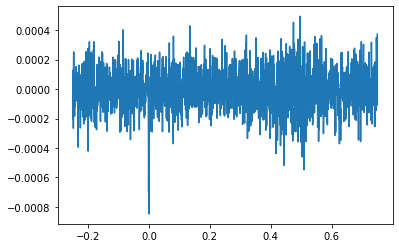

In [9]:
path = '/media/ushasi/Elements/Masters_Project_Data/TESS/sector1/'
entries = os.listdir(path)

hdu = fits.open(path+entries[1])
print(len(hdu))
# print(hdu[1].header)
df,tp, tf, _ = sort_data_centred(hdu,1,1,1,2000)
print(tf, tp)
plt.plot(np.array(df['phase']), np.array(df['flux']))
# print(len(df))
# plt.xlim(-0.005,0.005)
# print(print(np.array(df['flux'])[50:100]))

In [15]:
cr = (1,0)

print(type(cr)==tuple)

print(cr[1])

True
0


In [1]:
cols = ['flux_loc', 'flux_glob', 'id', 'pl_no', 'tperiod', 'tdur']
datatype = ['ar', 'ar', 'b', 'i', 'fl', 'fl']
fintype = [tf.float32, tf.float32, tf.string, tf.int8, tf.float32, tf.float32]
fl_l, fl_g, id, plno, tp, td = gc.read_tfr_record('../Data_Processing/testtrainsample', cols, datatype, fintype)

NameError: name 'tf' is not defined

In [3]:
cols = [ 'flux', 'id']
datatype = ['ar', 'b']
fintype = [tf.float32, tf.string]
fl, id = gc.read_tfr_record('../Data_Processing/testtrainsample', cols, datatype, fintype)

2022-08-16 19:02:42.923530: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-16 19:02:42.923567: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-16 19:02:42.923589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ushasi-HP-Pavilion-Notebook): /proc/driver/nvidia/version does not exist
2022-08-16 19:02:42.923914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(np.array(fl).shape)
# print(gc.byte_arr_to_np(id))

(50, 4, 4000)


In [ ]:
rv_entry=ascii.read('../../Catalogs/robovetter_label.dat')
rv_pl=np.array(rv_entry['tce_plnt_num'])
rv_label = np.array(rv_entry['label'])
rv_kepid=[('0000'+str(el)[:9])[-9:] for el in rv_entry['kepid']]
u1=np.array(rv_entry['u1'])
u2=np.array(rv_entry['u2'])
b=np.array(rv_entry['b'])
rpl=np.array(rv_entry['rpl_rstar'])
rorb=np.array(rv_entry['rorb_rstar'])

In [ ]:
print(np.mean(rpl))

In [ ]:
tab = ascii.read('../../Catalogs/ex_TCE_extra.tab')
print(np.mean(tab['koi_model_snr']))
val, bin, _ = plt.hist(tab['koi_model_snr'], bins=1000)
print(bin[np.argmax(val)])
print(val[:10], bin[:10])
plt.show


In [ ]:
hdu = fits.open('E:\\Masters_Project_Data\\TESS\\tess2021233042500-s0042-s0043-0000000090768237-00523_dvt.fits')
print(len(hdu))
print(hdu[1].header)

In [ ]:
plt.plot(hdu[1].data['TIME'],hdu[1].data['LC_DETREND'])

In [ ]:
#finding out mean noise layers in kepler... phase folded and unfolded
FILEPATH="E:\\Masters_Project_Data\\alienworlds_fps\\"
entries=os.listdir(FILEPATH)
x=0
noise=[]
for el in entries:
    hdu = fits.open(FILEPATH+el)
    lc = [c for c in hdu[1].data['LC_DETREND'] if not np.isnan(c)]
    #print(len(lc))
    noise.append(np.std(lc[:100]))
#print(noise)
    

In [ ]:
print(len(noise))
val, bin, _ = plt.hist(noise, bins=1000)
print(bin[np.argmax(val)])
print(val[:10], bin[:10])
print(np.mean(noise))

In [ ]:
#here's the trend in rorb...
filepath = '../Computation_Directory/Rpl_50.0/'
entries = os.listdir(filepath)
fig, ax = plt.subplots(1,1,figsize = (7,5))
ax.set_title('Variation of LC with Orbit')
ax.set_xlabel('Phase')
ax.set_ylabel('Flux')
for entry in entries:
    df = pd.read_csv(filepath+entry)
    ax.plot(np.array(df['frame']), np.array(df['u1_0.2_u2_0.2_b_0.0']), label=entry[8:-4])
ax.set_xscale('log')
ax.legend()
plt.savefig('rorbdemo2.png')
plt.show

In [ ]:
path='C:\\Users\\Hp\Desktop\\temp_finallist\\manda\\'
path='C:\\Users\\Hp\Documents\\FYProj\processed_directories\go_circles\\new_final_fits\\'
entry = os.listdir(path)

for el in entry:
    kid=np.where(np.array(rv_kepid)==str(el[-15:-6]))[0]
    if(len(kid)==0): 
        #print("not in catalog",el[-15:-6])
        continue
    kidf=[x for x in kid if(str(rv_pl[x])==str(el[-5:-4]))]
    if(len(kidf)==0): 
        #print("not in catalog",el[-5:-4])
        continue
    if(rv_label[kidf[0]]=='CAN'):  
        print(kidf,rv_label[kidf[0]],el) 

In [ ]:
print(ellc.lc.__doc__)

In [ ]:
t = np.arange(-0.25,0.75, 0.001)
spots_1 = [[30,180],[45,-45],[25,35],[0.2,0.8]]
flux = ellc.lc(t,radius_1=0.5,radius_2=0.48,sbratio=0,incl=90,ld_1='quad',ldc_1=[0.2,0.02],
shape_1='sphere', shape_2='sphere' )

flux2 = ellc.lc(t,radius_1=0.5,radius_2=0.48,sbratio=0,incl=90,ld_1='quad',ldc_1=[0.2,0.02],
shape_1='sphere', shape_2='love', hf_2=5 )

# flux2 = ellc.lc(t,radius_1=0.3,radius_2=0.003,sbratio=0.1,incl=90,ld_1='quad',ldc_1=[0.9,0.9],
# shape_1='sphere', shape_2='love', hf_1=4.5, hf_2=4.5, q=0.6)
fig, ax = plt.subplots(2,1,figsize=(7,7))
ax[0].set_title('Tidal Model:\n Rpl=Rst')
ax[1].set_title('Residual')
ax[1].set_xlabel('Phase')
ax[1].set_ylabel('Rigid-Fluid')
ax[0].set_ylabel('Flux')
ax[0].plot(t,flux,label='rigid')
ax[0].plot(t,flux2, label='fluid')
ax[0].legend()
ax[1].plot(t,flux-flux2)

#plt.xlim(-0.052,0.052)
plt.savefig('tides2.png')
plt.show()

In [ ]:
plt.plot(t,flux-flux2)


In [ ]:
def gausses(x, A1, m1, s1, A2, m2, s2):
    y = A1*np.exp(-(x-m1)**2/(2*s1**2)) + A2*np.exp(-(x-m2)**2/(2*s2**2))
    return(y)

def lorz(x,A1,x0,g, A2, x02, g2):
    y = A1 / (1*((x-x0)**2+(g/2)**2)) + A2 / (1*((x-x02)**2+(g2/2)**2))
    return(y)

def new_plar(ph,p,minus, plus,rorb):
    u1 = (plus + minus)/2
    u2 = (plus - minus)/2
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free(ph,p,u1,plus,rorb):
    u2 = plus - u1
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2])  
    return(a -1) 

def new_plar_free2(ph,p,u1,u2,rorb):
    znp = np.abs(rorb*np.sin(ph*np.pi))
    a= occultquad(znp,p,[u1,u2,])  
    return(a -1) 

In [ ]:
df = np.loadtxt('2d3d_0.1R_circ.csv')
frm = df[:,0]
d2 = df[:,1]
d3 = df[:,2]
#plt.plot(frm, d3-1)
plt.plot(frm, d3-1-new_plar_free2(frm/np.pi, 0.1, 0.0, 0.0, 2))
outdf = pd.DataFrame(zip(frm, d3-1, new_plar_free2(frm/np.pi, 0.1, 0.0, 0.0, 2)), columns=["frame","sim","model"])
outdf.to_csv('0.1R_circ_com.csv', sep=",", index=False)

In [ ]:
sim = dy.Simulator(100, 10000, 300, np.pi, 0,0)

#meg1 = dy.Megastructure(200, True, 20, ecc=0, o_vel=3, ph_offset=np.pi/3)
meg1 = dy.Megastructure(200, True, 20, ecc=0, o_vel=1, ph_offset=0)
# meg2 = dy.Megastructure(250, True, 10, ecc=0, o_vel=2,ph_offset=np.pi/2)
#meg3 = dy.Megastructure(350, True, 25, ecc=0.5, o_vel=1, per_off=np.pi/2)
sim.add_megs(meg1)
# sim.add_megs(meg2)
#sim.add_megs(meg3)

netlc=[]

for i in range(50):
    sim.initialize()
    sim.simulate_transit()
    netlc.append(sim.lc)
    
lc = np.mean(np.array(netlc), axis=0)
TA = dy.Transit_Animate(sim.road, sim.megs, lc, sim.frames)
TA.go(True,'multiann_1.gif')


In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5))
ax.set_title('Multi Planet LC', size=16)
ax.plot(sim.frames/np.pi,lc, color="#503f3f")
ax.set_xlabel('Phase', size=13)
ax.set_ylabel('Flux', size=13)
plt.savefig('fprez_multipl.png')


In [ ]:
##simple planet
sim = dy.Simulator(100, 10000, 300, np.pi, limb_u1=0.0, limb_u2=0)

#meg1 = dy.Megastructure(200, True, 20, isrot=True, incl=0, ecc=0.0, per_off=0)
meg1 = dy.Megastructure(200, False, 20, isrot=True, incl=0, ecc=0.0, per_off=0)
meg1.regular_polygons_2d(30,6)
meg2 = dy.Megastructure(200, False, 20, isrot=True, incl=0, ecc=0.0, per_off=0, elevation=0.3)
meg2.regular_polygons_2d(30,6)
sim.add_megs(meg1)
sim.add_megs(meg2)

netlc=[]

for i in range(50):
    sim.initialize()
    sim.simulate_transit()
    netlc.append(sim.lc)
    
lc = np.mean(np.array(netlc), axis=0)
TA = dy.Transit_Animate(sim.road, sim.megs, lc, sim.frames)
TA.go(True,'singleann2d_hex.gif')


In [ ]:
th = np.linspace(0,2*np.pi, 300)
R = 1

In [ ]:
store = pd.HDFStore('../../processed_directories/go_circles/analyse_circles/008110757_1')
data = store['data']
metadata = store.get_storer('data').attrs.metadata

print(metadata)
print(data)  

In [ ]:
def Prob(x, z, u):
    k=1-u/2
    y = ((1-u)*x + u*x**2/2)/k -z
    return(y)

def Prob2(x, z, u):
    k=(1-u)*R+u*np.pi*R/4
    y = ((1-u)*x + u*x*np.sqrt(R**2-x**2)/2*R + u*R*np.arcsin(x/R)/2)/k -z
    return(y)

In [ ]:
sol = root_scalar(Prob2,args=(1,0.1),bracket=[0,R])
plt.plot(np.linspace(0,1,200), Prob2(np.linspace(0,1,200), 0.2, 0.6))
print(sol.root, np.sin(sol.root),sol.iterations)

In [ ]:
ran_th=2*np.pi*np.random.rand(20000)
temp_z =np.sqrt(np.random.rand(20000))
#temp_z =0.9*np.ones(200)
ths = []
for el in temp_z:
    sol = root_scalar(Prob2,args=(el,0.0),bracket=[0,R])
    #print(el,sol.root)
    ths.append(sol.root)

ran_x = 10*np.asarray(ths)

#print(ran_rad, len(ran_rad))

In [ ]:
plt.figure(figsize=(5,5))
#plt.plot(R*np.cos(th), R*np.sin(th))
plt.scatter(ran_x*np.sin(ran_th), ran_x*np.cos(ran_th), s=2)
#plt.scatter(ran_rad*np.cos(ran_th)*ran_x, ran_rad*np.sin(ran_th)*ran_x, s=2)